In [161]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/pfc/miniconda3/envs/mac-distribution/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [162]:
import numpy

from tvb.simulator.lab import *
from tvb.datatypes.time_series import TimeSeriesRegion
import tvb.analyzers.fmri_balloon as bold
from tvb.simulator.plot import timeseries_interactive as timeseries_interactive

In [176]:
conn = connectivity.Connectivity.from_file()

# configure stimulus spatial pattern
weighting = numpy.zeros((76, ))
weighting[[0, 7, 13, 33, 42]] = numpy.array([2.0 ** -2, 2.0 ** -3, 2.0 ** -4, 2.0 ** -5, 2.0 ** -6])

# temporal profile
eqn_t = equations.Gaussian()
eqn_t.parameters["midpoint"] = 25000.0
eqn_t.parameters["sigma"] = 1.0

stimulus = patterns.StimuliRegion(temporal=eqn_t,
                                  connectivity=conn,
                                  weight=weighting)

sim = simulator.Simulator(
    model=models.Generic2dOscillator(a=numpy.array([0.5])),
    connectivity=conn,
    coupling=coupling.Linear(a=numpy.array([0.0126])),
    integrator=integrators.HeunDeterministic(dt=0.5),
    monitors=(
        monitors.TemporalAverage(period=1.0),
        monitors.Bold(period=500),
        monitors.ProgressLogger(period=5e3),
        ),
    stimulus=stimulus,
    simulation_length=60e3, # 1 minute simulation
).configure()

(tavg_time, tavg_data), (bold_time, bold_data), _ = sim.run()

WARNING  File 'hemispheres' not found in ZIP.
WARNING  random_state supplied for non-stochastic integration
   INFO  step 1 time 0.0005 s
   INFO  step 10001 time 5.0005 s
   INFO  step 20001 time 10.0005 s
   INFO  step 30001 time 15.0005 s
   INFO  step 40001 time 20.0005 s
   INFO  step 50001 time 25.0005 s
   INFO  step 60001 time 30.0005 s
   INFO  step 70001 time 35.0005 s
   INFO  step 80001 time 40.0005 s
   INFO  step 90001 time 45.0005 s
   INFO  step 100001 time 50.0005 s
   INFO  step 110001 time 55.0005 s


In [178]:
#Make the lists numpy.arrays for easier use.
LOG.info("Converting result to array...")
TAVG_TIME = numpy.array(tavg_time)
BOLD_TIME = numpy.array(bold_time)
BOLD = numpy.array(bold_data)
TAVG = numpy.array(tavg_data)

#Create TimeSeries instance
tsr = TimeSeriesRegion(connectivity = conn,
                       data = TAVG,
                       time = TAVG_TIME,
                       sample_period = 2.)
tsr.configure()

#Create and run the monitor/analyser
bold_model = bold.BalloonModel(time_series = tsr)
bold_data  = bold_model.evaluate()

/Users/pfc/Documents/GitHub/tvb-root/tvb_library/tvb/analyzers/fmri_balloon.py:314: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return numpy.array([k1, k2, k3])


Text(0.5, 0, 'Time (ms)')

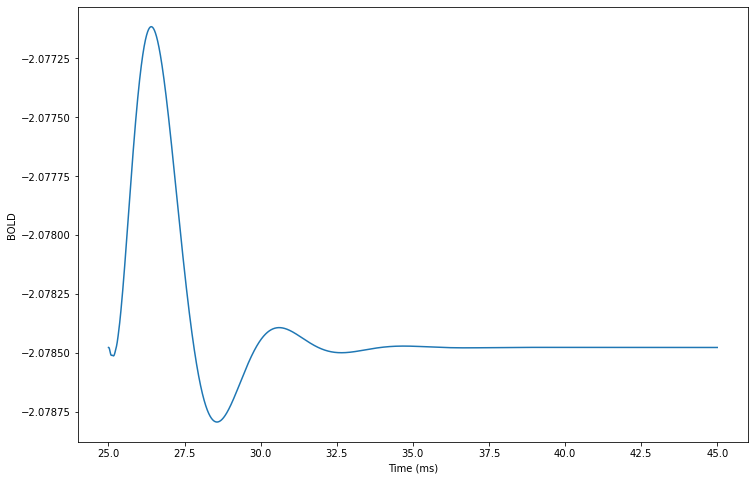

In [179]:
plt.figure(figsize=(12,8))

#plt.subplot(212)
plt.plot(bold_data.time[25000:45000], bold_data.data[25000:45000, 0, [42], 0])
plt.ylabel("BOLD")

plt.xlabel('Time (ms)')

### Stephan 2007:

$$
\frac{ds}{dt} = x - \kappa\,s - \gamma \,(f-1) \\
\frac{df}{dt} = s \\
\frac{dv}{dt} = \frac{1}{\tau_o} \, (f - v^{1/\alpha})\\
\frac{dq}{dt} = \frac{1}{\tau_o}(f \, \frac{1-(1-E_0)^{1/\alpha}}{E_0} - v^{1/\alpha} \frac{q}{v})\\
\kappa = \frac{1}{\tau_s}\\
\gamma = \frac{1}{\tau_f}
$$

In [ ]:
def balloon_dfun(self, state_variables, neural_input, local_coupling=0.0):
    s = state_variables[0, :]
    f = state_variables[1, :]
    v = state_variables[2, :]
    q = state_variables[3, :]

    x = neural_input[0, :]

    ds = x - (1. / self.tau_s) * s - (1. / self.tau_f) * (f - 1)
    df = s
    dv = (1. / self.tau_o) * (f - v ** (1. / self.alpha))
    dq = (1. / self.tau_o) * ((f * (1. - (1. - self.E0) ** (1. / f)) / self.E0) -
                              (v ** (1. / self.alpha)) * (q / v))

    return numpy.array([ds, df, dv, dq])

In [ ]:
tau_s = Float(
    label=r":math:`\tau_s`",
    default=1.54,
    required=True,
    doc="""Balloon model parameter. Time of signal decay (s)""")

tau_f = Float(
    label=r":math:`\tau_f`",
    default=1.44,
    required=True,
    doc=""" Balloon model parameter. Time of flow-dependent elimination or
    feedback regulation (s). The average  time blood take to traverse the
    venous compartment. It is the  ratio of resting blood volume (V0) to
    resting blood flow (F0).""")

tau_o = Float(
    label=r":math:`\tau_o`",
    default=0.98,
    required=True,
    doc="""
    Balloon model parameter. Haemodynamic transit time (s). The average
    time blood take to traverse the venous compartment. It is the  ratio
    of resting blood volume (V0) to resting blood flow (F0).""")

alpha = Float(
    label=r":math:`\tau_f`",
    default=0.32,
    required=True,
    doc="""Balloon model parameter. Stiffness parameter. Grubb's exponent.""")

TE = Float(
    label=":math:`TE`",
    default=0.04,
    required=True,
    doc="""BOLD parameter. Echo Time""")

V0 = Float(
    label=":math:`V_0`",
    default=4.0,
    required=True,
    doc="""BOLD parameter. Resting blood volume fraction.""")

E0 = Float(
    label=":math:`E_0`",
    default=0.4,
    required=True,
    doc="""BOLD parameter. Resting oxygen extraction fraction.""")

epsilon = NArray(
    label=":math:`\epsilon`",
    default=numpy.array([0.5]),
    domain=Range(lo=0.5, hi=2.0, step=0.25),
    required=True,
    doc=""" BOLD parameter. Ratio of intra- and extravascular signals. In principle  this
    parameter could be derived from empirical data and spatialized.""")

nu_0 = Float(
    label=r":math:`\nu_0`",
    default=40.3,
    required=True,
    doc="""BOLD parameter. Frequency offset at the outer surface of magnetized vessels (Hz).""")

r_0 = Float(
    label=":math:`r_0`",
    default=25.,
    required=True,
    doc=""" BOLD parameter. Slope r0 of intravascular relaxation rate (Hz). Only used for
    ``revised`` coefficients. """)

In [180]:
def mod_balloon_dfun(self, state_variables, neural_input, local_coupling=0.0):
    s = state_variables[0, :]
    f = state_variables[1, :]
    v = state_variables[2, :]
    q = state_variables[3, :]

    x = neural_input[0, :]

    ds = x - (1. / self.tau_s) * s - (1. / self.tau_f) * (f - 1)
    df = s
    dv = (1. / self.tau_o*0.5) * (f - v ** (1. / self.alpha))
    dq = (1. / self.tau_o*0.5) * ((f * (1. - (1. - self.E0) ** (1. / f)) / self.E0) -
                              (v ** (1. / self.alpha)) * (q / v))

    return numpy.array([ds, df, dv, dq])

In [181]:
bold.BalloonModel.balloon_dfun = mod_balloon_dfun

In [182]:
#Create and run the monitor/analyser
bold_model = bold.BalloonModel(time_series = tsr)
bold_data  = bold_model.evaluate()

/Users/pfc/Documents/GitHub/tvb-root/tvb_library/tvb/analyzers/fmri_balloon.py:314: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return numpy.array([k1, k2, k3])


Text(0.5, 0, 'Time (ms)')

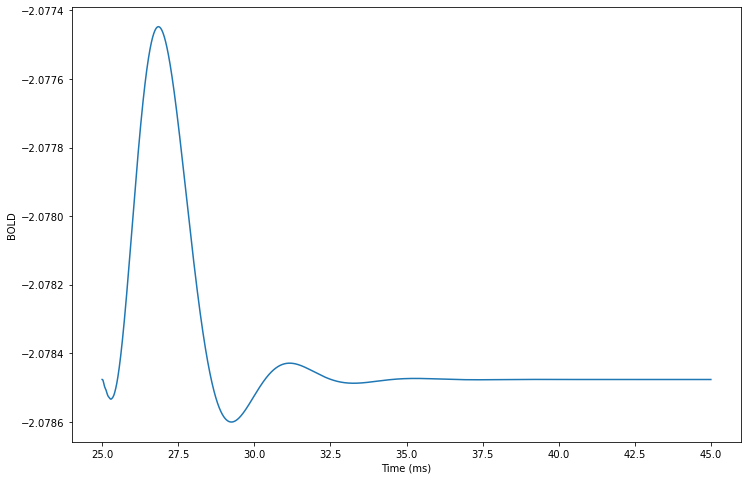

In [183]:
plt.figure(figsize=(12,8))

#plt.subplot(212)
plt.plot(bold_data.time[25000:45000], bold_data.data[25000:45000, 0, [42], 0])
plt.ylabel("BOLD")

plt.xlabel('Time (ms)')

`tau_s` - kappa => doubling rate of signal decay leads to lesser response maximum and reduced undershoot  'rate constant of the vasodilatory signal decay'

`tau_f` - gamma => doubling leads to half value, similar shape in terms of range but more pronounced overshoot & rebound 'rate constant for autoregulatory feedback by blood flow'

`tau_o` - tau => mean transit time of blood, avg time blood takes to traverse venous compartment, corresponds to ratio of resting blood volume V_0 to resting blood floow F_0: V_0/F_0 'transit time'
=> * 0.5 => big change, less undershoot - what other parameter change is this similar to? why?

`alpha` - 'Stiffness parameter. Grubb's exponent.', could replace w Buxton's formulation but less generalisability (footnote 3 Stephan2007) => increase -> nonlinear increase in BOLD response - 2x alpha => ~50% increase in BOLD response, 10x alpha ~ 100% increase in BOLD response

`E0` - increase -> BOLD decrease
drop EO (oxygen extraction fraction) by 10% -> ~ 10x BOLD response - makes sense, signal is due to diamagnetic property of oxyhemoglobin
increase E0 by 10% -> we get a negative valued BOLD response - doesn't make sense but a reduction would mean - more oxygen extracted -> more deoxyhemoglobin - less signal


neither (`alpha`, `E0`) have ~ any effect on response shape

# ~ extracting hemodynamic state equation parameters / new functionality

In [ ]:
#~ lb.variables_of_interest = ["V", "W", "Z"]

In [141]:
%matplotlib inline

In [142]:
%load_ext autoreload

In [143]:
%autoreload 2

In [144]:
import numpy as np
import matplotlib.pylab as plt

In [145]:
from tvb.simulator.lab import *

In [146]:
from tvb.simulator.backend.nb_mpr import NbMPRBackend

In [147]:
N = 2
conn = connectivity.Connectivity()
conn.motif_all_to_all(number_of_regions=N)
conn.centres_spherical(number_of_regions=N)
conn.speed = np.r_[np.inf]

In [148]:
conn.configure()

In [149]:
weighting = patterns.StimuliRegion.get_default_weights(N)
weighting[0] = 4.

# temporal profile
eqn_t = equations.Gaussian()
eqn_t.parameters["midpoint"] = 11000.0
eqn_t.parameters["sigma"] = 100.0

stimulus = patterns.StimuliRegion(temporal=eqn_t,
                                  connectivity=conn,
                                  weight=weighting)

In [150]:
sim = simulator.Simulator(
    model = models.MontbrioPazoRoxin(),
    connectivity = conn,
    integrator = integrators.HeunStochastic(
        dt = 0.01, 
        noise = noise.Additive(nsig=np.r_[0.01,0.02])
    ),
    initial_conditions=np.zeros( (1,2,N,1) ),
    stimulus=stimulus,
    monitors=[monitors.Raw()]
).configure()

In [151]:
backend = NbMPRBackend()

In [152]:
%%capture
(raw_t, raw_d), = backend.run_sim(sim, simulation_length=30000)

In [153]:
raw_t.shape, raw_d.shape

((3000000,), (3000000, 2, 2, 1))

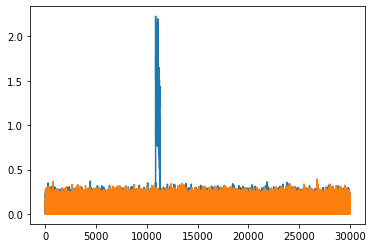

In [154]:
plt.plot(raw_t, raw_d[:, 0,:,0])

In [156]:
def replay_monitor(raw_d, sim):
    """ Assumes that the raw_d was produced in consistency with the simulator used."""
    assert len(sim.monitors) == 1, "Only one monitor at a time can be replayed."    
    res = [out for out in [ sim.monitors[0].record(step, sim.model.observe(state)) for step, state in enumerate(raw_d)] if out is not None]
    b_t, b_d = zip(*res)
    b_t, b_d = np.array(b_t), np.array(b_d)
    return b_t, b_d

In [160]:
sim = simulator.Simulator(
    model = models.MontbrioPazoRoxin(variables_of_interest=['r']),
    connectivity = conn,
    integrator = integrators.HeunStochastic(
        dt = 0.01, 
        noise = noise.Additive(nsig=np.r_[0.01,0.02])
    ),
    initial_conditions=np.zeros( (1,2,N,1) ),
    stimulus=stimulus,
    monitors=[monitors.Bold(period=10., include_svars=True)], # period=500 #monitors.BoldBalloonWindkessel(period=10., V0=0.02, tau_s=0.65, alpha=0.32, include_svars=True)],

).configure()

TraitTypeError: Valid kwargs for type <class 'tvb.simulator.monitors.Bold'> are: ('period', 'hrf_kernel', 'hrf_length', 'variables_of_interest', 'gid'). You have given: 'include_svars'

In [158]:
b_t, b_d = replay_monitor(raw_d, sim)

IndexError: index 1 is out of bounds for axis 1 with size 1

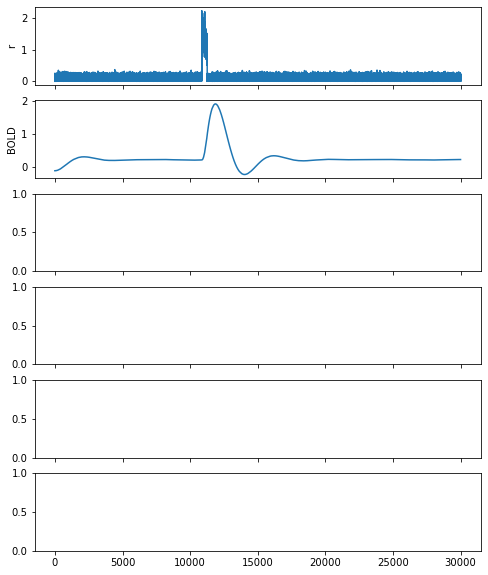

In [159]:
fig, axs = plt.subplots(nrows=6, sharex=True, figsize=(8,10))
axs[0].plot(raw_t,raw_d[:,0,0,0])
axs[0].set(ylabel='r')
for i, (ax, label) in enumerate( zip(axs[1:], ['BOLD', 's', 'f', 'v', 'q'])):
    ax.plot(b_t[:], b_d[:,i,0,0])
    ax.set(ylabel=label)

In [ ]:
conn = connectivity.Connectivity.from_file()

# configure stimulus spatial pattern
weighting = numpy.zeros((76, ))
weighting[[0, 7, 13, 33, 42]] = numpy.array([2.0 ** -2, 2.0 ** -3, 2.0 ** -4, 2.0 ** -5, 2.0 ** -6])

# temporal profile
eqn_t = equations.Gaussian()
eqn_t.parameters["midpoint"] = 25000.0
eqn_t.parameters["sigma"] = 1.0 #2000.0

stimulus = patterns.StimuliRegion(temporal=eqn_t,
                                  connectivity=conn,
                                  weight=weighting)

sim = simulator.Simulator(
    model=models.Generic2dOscillator(a=numpy.array([0.5])),
    connectivity=conn,
    coupling=coupling.Linear(a=numpy.array([0.0126])),
    integrator=integrators.HeunDeterministic(dt=0.5),
    monitors=(
        monitors.TemporalAverage(period=1.0),
        monitors.Bold(period=500),
        monitors.ProgressLogger(period=5e3),
        ),
    stimulus=stimulus,
    simulation_length=60e3, # 1 minute simulation
).configure()

(tavg_time, tavg_data), (bold_time, bold_data), _ = sim.run()

#Make the lists numpy.arrays for easier use.
LOG.info("Converting result to array...")
TAVG_TIME = numpy.array(tavg_time)
BOLD_TIME = numpy.array(bold_time)
BOLD = numpy.array(bold_data)
TAVG = numpy.array(tavg_data)

#Create TimeSeries instance
tsr = TimeSeriesRegion(connectivity = conn,  # inc'd this
                       data = TAVG,
                       time = TAVG_TIME,
                       sample_period = 2.)
tsr.configure()

#Create and run the monitor/analyser
bold_model = bold.BalloonModel(time_series = tsr)
bold_data  = bold_model.evaluate()

plt.figure(figsize=(12,8))

#plt.subplot(212)
plt.plot(bold_data.time[25000:45000], bold_data.data[25000:45000, 0, [42], 0])
plt.ylabel("BOLD")

plt.xlabel('Time (ms)')